# MTRNN.ipynb

Using an Multiple-Timescal RNN to learn to trace circles and figure eights.

The MTRNN architecture is a modified version of the network in Yamashita & Tani 2008, [Emergence of Functional Hierarchy in a Multiple Timescale Neural Network Model: A Humanoid Robot Experiment](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000220#s4).

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import lovely_tensors as lt
lt.monkey_patch()
%cd ./data/

/home/z/Dropbox (OIST)/code/python/pytorch/deep_explorations/rnn/data


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cuda:0


In [6]:
# Load training data
fname = 'switch_circle2_circle2.pkl'
# fname = 'infty10_1.pkl'
with open(fname, 'rb') as f:
    coordinates = pickle.load(f)

Coordinates shape: torch.Size([995, 2])


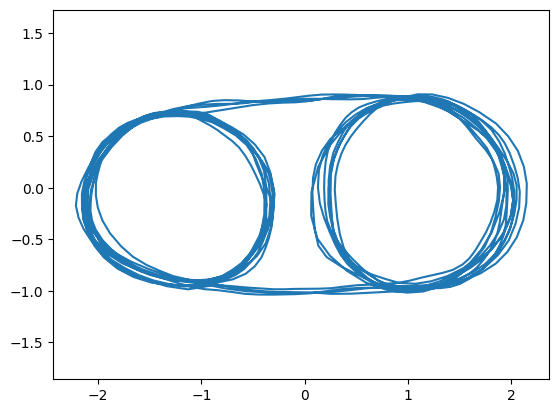

In [7]:
# plot the loaded array
fig = plt.figure()
plt.axis('equal')
plt.plot(coordinates[:,0], coordinates[:,1])

coordinates = torch.tensor(coordinates, dtype=torch.float32)
print(f"Coordinates shape: {coordinates.shape}")

In [8]:
# Create the network, the optimizer, and the loss function
# NOTICE there are no batches. Learning single pattern.
features_size = 2  # this shouldn't change
layer_sizes = [10, 40, 8]  # size of L0, H0, and H1 layers
taus = [4, 80]  # time constant for H1 and H2, respectively
nonlinearity = 'tanh'  # tanh or relu
lr = 3e-4  # learning rate
all_generated = []

torch.manual_seed(345)

class MTRNN(nn.Module):
    def __init__(self, features_size, layer_sizes, taus, nonlinearity):
        super(MTRNN, self).__init__()
        self.features_size = features_size
        self.layer_sizes = layer_sizes
        self.rt0 = 1. / taus[0]
        self.rt1 = 1./ taus[1]
        self.nonlinearity = nonlinearity
        self.L0 = nn.Linear(features_size + layer_sizes[1],
                            layer_sizes[0],
                            device=device)
        self.L1 = nn.Linear(layer_sizes[0],
                            features_size,
                            device=device)
        self.H0 = nn.RNNCell(features_size + layer_sizes[2],
                             layer_sizes[1],
                             nonlinearity=nonlinearity,
                             device=device)
        self.H1 = nn.RNNCell(layer_sizes[1],
                             layer_sizes[2],
                             nonlinearity=nonlinearity,
                             device=device)
        if nonlinearity == 'tanh':
            self.nl = torch.tanh
        elif nonlinearity == 'relu':
            self.nl = torch.relu
        else:
            raise ValueError(f"Invalid nonlinearity {nonlinearity}")

    def forward(self, x, h0, h1):
        """ Forward step.

            x, h0, h1 are expecte to be 1-dimensional tensors
            with lengths 2, layer_sizes[1], layer_sizes[2].
        """
        x_h0 = torch.cat((x, h0))
        x_h1 = torch.cat((x, h1))        
        L0_out = self.nl(self.L0(x_h0))
        L1_out = self.L1(L0_out)
        h0p = self.H0(x_h1, h0)
        h1p = self.H1(h0, h1)
        h0 = (1. - self.rt0) * h0 + self.rt0 * h0p
        h1 = (1. - self.rt1) * h1 + self.rt1 * h1p
        return L1_out, h0, h1


def sequential_forward(rnn, inputs, init_h0=None, init_h1=None):
    """ Run the RNN cell for all inputs, return all outputs.
    
        Args:
            rnn: a MTRNN cell
            inputs: (k, 2)-shaped tensor
        Returns:
            (k, 2)-shaped tensor with outputs for each input step.
        """
    if init_h0 == None:
        h0 = torch.zeros(rnn.layer_sizes[1]).to(device)
        # h0 = 0.1 * torch.randn(rnn.layer_sizes[1]).to(device)
    else:
        h0 = init_h0
    if init_h1 == None:
        h1 = torch.zeros(rnn.layer_sizes[2]).to(device)
        # h1 = 0.1 * torch.randn(rnn.layer_sizes[2]).to(device)
    else:
        h1 = init_h1
    out_cache = torch.empty((inputs.shape[0],
                             features_size),
                            device=device,
                            dtype=torch.float32)
    for idx, input in enumerate(inputs):
        out, h0, h1 = rnn(input, h0, h1)
        out_cache[idx, :] = out
    return out_cache

mtrnn = MTRNN(features_size, layer_sizes, taus, nonlinearity)

optim = torch.optim.Adam(mtrnn.parameters(), lr=lr, weight_decay=1e-5)

loss = nn.MSELoss(reduction='mean')

In [21]:
# training loop
n_epochs = 600  # number of epochs
coordinates = coordinates.to(device)

for epoch in range(n_epochs):
    optim.zero_grad()
    out_cache  = sequential_forward(mtrnn, coordinates[:-1])
    error = loss(out_cache, coordinates[1:])
    error.backward()
    optim.step()
    if epoch % 5 == 0:
        print(f"Error at epoch {epoch} = {error}")

Error at epoch 0 = 0.005982125177979469
Error at epoch 5 = 0.005959291942417622
Error at epoch 10 = 0.005936543922871351
Error at epoch 15 = 0.00591387739405036
Error at epoch 20 = 0.005891296546906233
Error at epoch 25 = 0.005868864711374044
Error at epoch 30 = 0.00595783069729805
Error at epoch 35 = 0.007755771279335022
Error at epoch 40 = 0.006133951246738434
Error at epoch 45 = 0.006125586107373238
Error at epoch 50 = 0.0061413305811584
Error at epoch 55 = 0.006002463866025209
Error at epoch 60 = 0.005910186097025871
Error at epoch 65 = 0.0059009334072470665
Error at epoch 70 = 0.00585697777569294
Error at epoch 75 = 0.00580785796046257
Error at epoch 80 = 0.005782692693173885
Error at epoch 85 = 0.005754769314080477
Error at epoch 90 = 0.005723144393414259
Error at epoch 95 = 0.005695230793207884
Error at epoch 100 = 0.0056693521328270435
Error at epoch 105 = 0.005643948912620544
Error at epoch 110 = 0.005619073752313852
Error at epoch 115 = 0.005594972521066666
Error at epoch 120

In [22]:
# Generate a trajectory
n_points = 1000
# coordinate = torch.tensor([-1, -1], dtype=torch.float32)
coordinate = coordinates[0]

def generate_trajectory(init_coordinate, n_points):
    gen_coordinates = torch.empty((n_points, 2)).to(device)
    coordinate = init_coordinate.to(device)
    h0 = torch.zeros(layer_sizes[1]).to(device)
    h1 = torch.zeros(layer_sizes[2]).to(device)
    # h0 = 0.2 * torch.randn(layer_sizes[1]).to(device)
    # h1 = 0.2 * torch.randn(layer_sizes[2]).to(device)
    with torch.no_grad():
        for point_idx in range(n_points):
            coordinate, h0, h1 = mtrnn(coordinate, h0, h1)
            gen_coordinates[point_idx, :] = coordinate
    return gen_coordinates.cpu().detach().numpy()

gen_coordinates = generate_trajectory(coordinate, n_points)
all_generated.append(gen_coordinates)

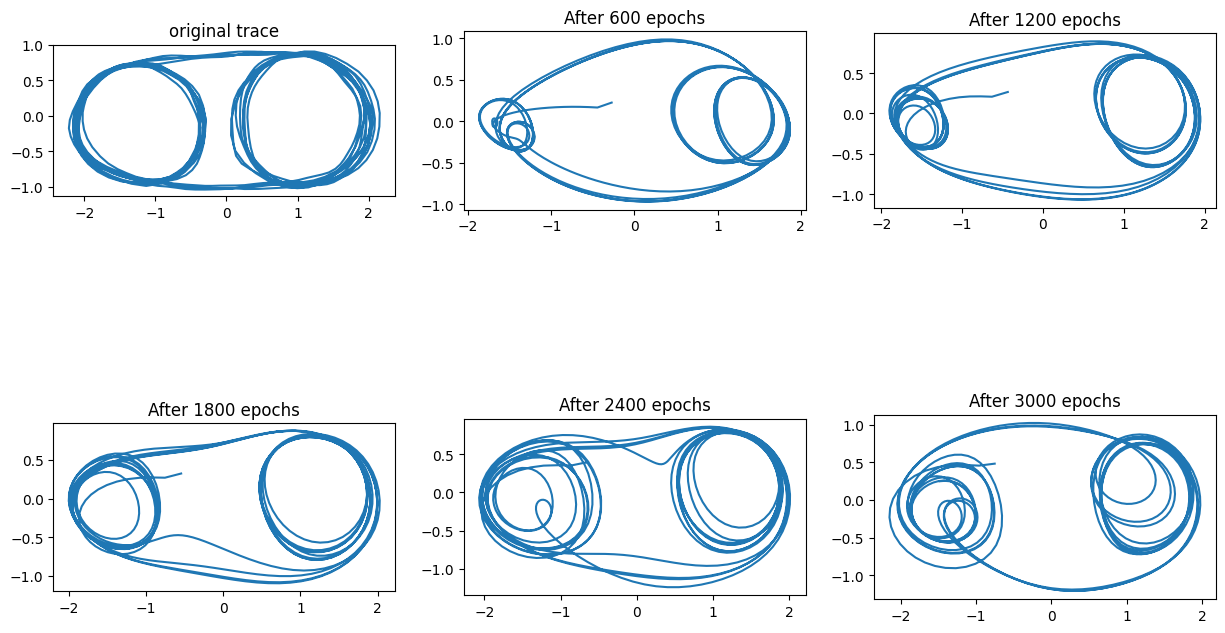

In [23]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5*n_cols, 4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates.cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

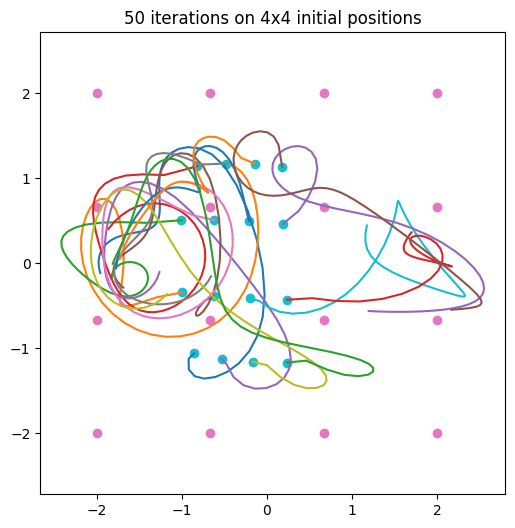

In [9]:
# plot a direction field
lim_x = 2. # largest magnitude of x
lim_y = 2.
N_x = 4 # number of points in x dimension
N_y = 4
n_points = 50
#df_fig = plt.figure(figsize = (10,10))
fig = plt.figure(figsize=(6,6))
plt.xlim(-1.1*lim_x, 1.1*lim_x)
plt.ylim(-1.1*lim_y, 1.1*lim_y)
plt.axis('equal')
plt.title(f'{n_points} iterations on {N_x}x{N_y} initial positions')
for x in np.linspace(-lim_x, lim_x, N_x):
    for y in np.linspace(-lim_y, lim_y, N_y):
        #print(f"x = {x}, y = {y}")
        plt.scatter([x], [y], color='tab:pink')
        coordinate = torch.tensor([x, y], dtype=torch.float32)
        trajectory = generate_trajectory(coordinate, n_points)
        plt.scatter([trajectory[0, 0]], [trajectory[0,1]], color='tab:cyan')
        plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()

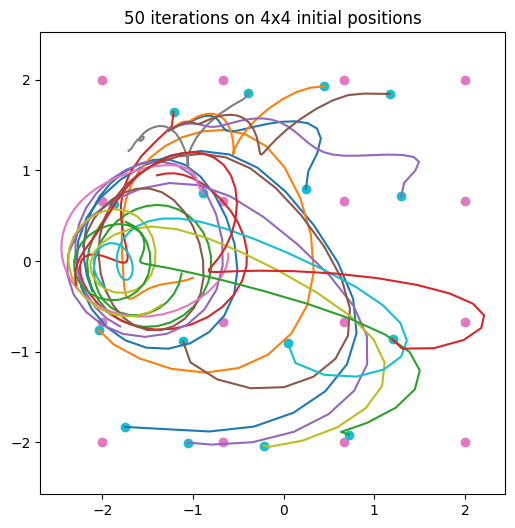

In [45]:
# plot a direction field
lim_x = 2. # largest magnitude of x
lim_y = 2.
N_x = 4 # number of points in x dimension
N_y = 4
n_points = 50
#df_fig = plt.figure(figsize = (10,10))
fig = plt.figure(figsize=(6,6))
plt.xlim(-1.1*lim_x, 1.1*lim_x)
plt.ylim(-1.1*lim_y, 1.1*lim_y)
plt.axis('equal')
plt.title(f'{n_points} iterations on {N_x}x{N_y} initial positions')
for x in np.linspace(-lim_x, lim_x, N_x):
    for y in np.linspace(-lim_y, lim_y, N_y):
        #print(f"x = {x}, y = {y}")
        plt.scatter([x], [y], color='tab:pink')
        coordinate = torch.tensor([x, y], dtype=torch.float32)
        trajectory = generate_trajectory(coordinate, n_points)
        plt.scatter([trajectory[0, 0]], [trajectory[0,1]], color='tab:cyan')
        plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()